In [1]:

import torch 
from ebm_pkg.models import get_model
from ebm_pkg.ebm.sampler import Sampler
import numpy as np 
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf
from ebm_pkg.datasets import CIFAR10_MEAN, CIFAR10_STD, MNIST_MEAN, MNIST_STD, get_datasets

data_path = '/data3/bumjin/bumjin_data'
data='fashion_mnist'
train_dataset, valid_dataset = get_datasets(data, data_path=data_path)
path = f"../results/ebm/{data}/cnn/seed_1" #/checkpoint_{checkpoint}"
flags = OmegaConf.load(f"{path}/config.yaml")

configs = {
    "cnn" : (1, flags.activation, flags.cnn_dim, None), 
    "resnet18" : (1, flags.activation, flags.cnn_dim, flags.avg_pool_size)
}
out_features, activation, cnn_dim, last_avg_kernel_size = configs[flags.model]
model = get_model(flags.model, 
                in_channels=flags.in_channels,
                out_features=out_features,
                activation=activation,
                cnn_dim=cnn_dim,
                last_avg_kernel_size=last_avg_kernel_size)
model.load_state_dict( torch.load(f"{path}/model.pt"))

sampler = Sampler(flags.img_size, flags.maxlen)
sampler.load(f"{path}/buffer.pt")

cnn


In [2]:
def convert_to_img(tensor, means, stds):
    means = torch.tensor(means).view(len(means), 1,1)
    stds = torch.tensor(stds).view(len(means), 1,1)
    img = (tensor * stds) + means
    img = img.permute(1,2,0).numpy()
    img = img*255
    img = img.astype(int)
    img = img.clip(0,255)
    return img 

means = CIFAR10_MEAN if 'cifar' in flags.data else MNIST_MEAN
stds = CIFAR10_STD if 'cifar' in flags.data else MNIST_STD

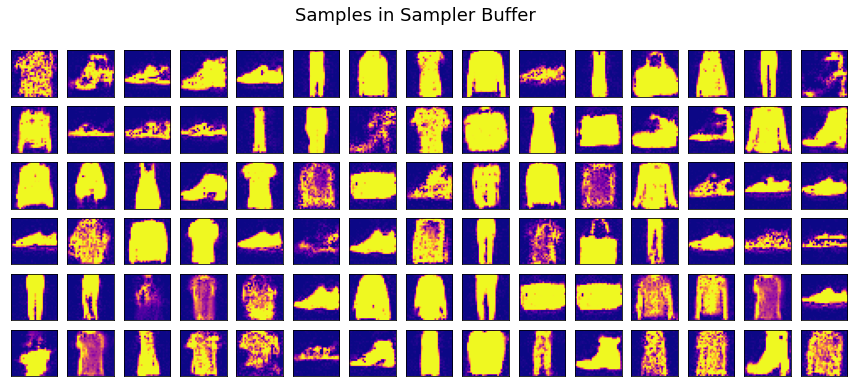

In [3]:

batch_size = 100
np.random.seed(11)
# neg_samples = sampler.sample(batch_size=batch_size, random=False) 
neg_samples = sampler.buffer[:batch_size]

N = 15
D = batch_size // N
ratio = 1.0
fig, axes = plt.subplots(D, N, figsize=(N*ratio, D*ratio))
fig.suptitle("Samples in Sampler Buffer", fontsize=18)

axes = axes.flat

for s in range(N):
    for i in range(D):
        sample=neg_samples[s*D + i]
        ax = next(axes)
        img = convert_to_img(sample, means, stds)
        ax.imshow(img, cmap='plasma')
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title(f"S:{s}")
# plt.tight_layout()

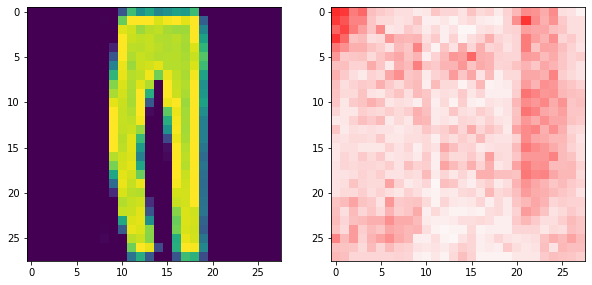

In [4]:
from ebm_pkg.input_attribs import get_input_attrib_energy
from matplotlib.colors import ListedColormap

def process_heatmap(R, my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))):
    power = 1.0
    b = 10*((np.abs(R)**power).mean()**(1.0/power))
    my_cmap[:,0:3] *= 0.99
    my_cmap = ListedColormap(my_cmap)
    return (R, {"cmap":my_cmap, "vmin":-b, "vmax":b, "interpolation":'nearest'} )
    
    
inputattrib = get_input_attrib_energy('smoothgrad')
index = 2
x = valid_dataset[index][0]

fig ,axes = plt.subplots(1,2, figsize=(10,5))
axes = axes.flat
ax = next(axes)
img = convert_to_img(x, means=means, stds=stds)
ax.imshow(img)

a = inputattrib(model, x)
img, kwargs = process_heatmap(a.float())
ax = next(axes)
ax.imshow(img, **kwargs)


100%|██████████| 100/100 [00:00<00:00, 186.66it/s]


Text(0.5, 1.0, 'grad')

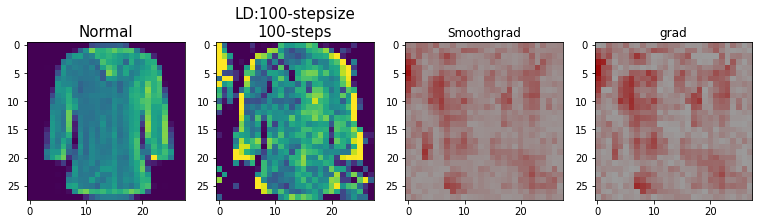

In [29]:
index = 4
x = valid_dataset[index][0]

fig ,axes = plt.subplots(1,4, figsize=(13,5))
axes = axes.flat
ax = next(axes)
img = convert_to_img(x, means=means, stds=stds)
ax.imshow(img)
ax.set_title("Normal", fontsize=15)


lagevian_steps = 100
lagevian_step_size = 5 
neg_samples, _, buffer, _= sampler.langevian_dynamics(model, x.unsqueeze(0), lagevian_steps=lagevian_steps, lagevian_step_size=lagevian_step_size,  return_dynamics=False, verbose=True, reversed=True)

img = convert_to_img(neg_samples.squeeze(0).detach(), means=means, stds=stds)
ax = next(axes)
ax.imshow(img)
ax.set_title(f"LD:{lagevian_steps}-stepsize\n{lagevian_steps}-steps", fontsize=15)

inputattrib = get_input_attrib_energy('smoothgrad')
a = inputattrib(model, neg_samples.squeeze(0))
img, kwargs = process_heatmap(a.detach().float().numpy())
ax = next(axes)
ax.imshow(img, **kwargs)
ax.set_title("Smoothgrad")

inputattrib = get_input_attrib_energy('grad')
a = inputattrib(model, neg_samples.squeeze(0))
img, kwargs = process_heatmap(a.detach().float().numpy())
ax = next(axes)
ax.imshow(img, **kwargs)
ax.set_title("grad")